In [4]:
import datetime
import numpy as np
import os
import pandas as pd
import scipy
import time
import xarray as xr

import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

### Data retrieval

##### Pickle load

In [2]:
import pickle
with open('../backup/KillTC-storm_tracks.pkl', 'rb') as handle:
    storage = pickle.load(handle)

##### Pickle dump

In [332]:
import pickle
with open('../backup/KillTC-storm_tracks.pkl', 'wb') as handle:
    pickle.dump(storage, handle)

##### Relevant directories to model data

In [2]:
run_dirs = {'AM2.5_tc_ctrl': '/tigress/wenchang/analysis/TC/AM2.5/CTL1990s_tigercpu_intelmpi_18_540PE/model_out/POSTP',
            'AM2.5_tc_ktc2': '/tigress/wenchang/analysis/TC/AM2.5ktc2/CTL1990s_killtc13-13-15_tigercpu_intelmpi_18_540PE/modelout/POSTP',
            'HIRAM_tc_ctrl': '/tigress/wenchang/analysis/TC/HIRAM/CTL1990s_v201910_tigercpu_intelmpi_18_540PE/model_out/POSTP',
            'HIRAM_tc_ktc2': '/tigress/wenchang/analysis/TC/HIRAMktc2/CTL1990s_v201910_killtc13-13-15_tigercpu_intelmpi_18_540PE/modelout/POSTP'}

track_dirs = {'AM2.5_tc_ctrl': '/tigress/wenchang/MODEL_OUT/AM2.5/CTL1990s_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_1C_330k',
              'AM2.5_tc_ktc2': '/tigress/wenchang/MODEL_OUT/AM2.5ktc2/CTL1990s_killtc13-13-15_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_1C_330k',
              'HIRAM_tc_ctrl': '/tigress/wenchang/MODEL_OUT/HIRAM/CTL1990s_v201910_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_2p5C_330k',
              'HIRAM_tc_ktc2': '/tigress/wenchang/MODEL_OUT/HIRAMktc2/CTL1990s_v201910_killtc13-13-15_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_1C_330k'}

##### Generate model data analysis DataFrame if pickle is outdated

In [7]:
storm_types = ['TS', 'C15w']

storage = {storm_type: {} for storm_type in storm_types}

for storm_type in storm_types:
    for model_run in track_dirs.keys():
        storage[storm_type][model_run] = None
        dirname = track_dirs[model_run]
        fnames = [[os.path.join(dirname, file, 'Harris.TC', f) for f in os.listdir(os.path.join(dirname, file, 'Harris.TC')) 
                   if '{0}.world'.format(storm_type) in f] 
                  for file in sorted(os.listdir(dirname))]

        fnames = [item for sublist in fnames for item in sublist]

        storage[storm_type][model_run] = pd.concat([lmh_parser(os.path.join(dirname, fname)) for fname in fnames])

Get individual storm durations

In [8]:
storm_types = ['TS', 'C15w']

storm_durations = {storm_type: {} for storm_type in storm_types}

for storm_type in storm_types:
    for model_run in track_dirs.keys():
        temp = storage[storm_type][model_run].copy()
        durations = []
        # Crude method assuming storms are continuous (get length of DataFrame with a given storm_id, divide by 4 to get days)
        storm_durations[storm_type][model_run] = temp['storm_id'].value_counts() / 4
        # More robust method (convert to datetime) is slower 
        # temp['time'] = pd.to_datetime(temp['time'], format='%Y%m%d%H')
        
        # Rejoin durations to DataFrame 
        storm_durations[storm_type][model_run] = storm_durations[storm_type][model_run].reset_index().rename(columns={'storm_id': 'duration', 'index': 'storm_id'})
        storage[storm_type][model_run] = storage[storm_type][model_run].merge(storm_durations[storm_type][model_run], how='left')

In [9]:
storage

{'TS': {'AM2.5_tc_ctrl':        storm_num   storm_id        time     lon    lat     slp  max_wnd  \
  0           0001  2001-0001  2001010106  180.23 -18.26  984.89    22.67   
  1           0001  2001-0001  2001010112  180.86 -18.80  984.60    25.60   
  2           0001  2001-0001  2001010118  181.33 -19.12  986.06    25.29   
  3           0001  2001-0001  2001010200  182.28 -19.73  982.27    24.08   
  4           0001  2001-0001  2001010206  183.03 -20.51  981.77    27.08   
  ...          ...        ...         ...     ...    ...     ...      ...   
  303748      0081  2000-0081  2000123000  130.21 -17.34  997.10    13.62   
  303749      0081  2000-0081  2000123006  129.40 -17.75  995.99    11.86   
  303750      0081  2000-0081  2000123012  128.64 -17.43  999.77    11.75   
  303751      0081  2000-0081  2000123018  128.23 -17.37  998.13    10.48   
  303752      0081  2000-0081  2000123100  128.09 -17.60  999.27    11.32   
  
            flag  duration  
  0       261.65     

### Visualization

#### Distribution + Kolmogorov-Smirnov test statistics

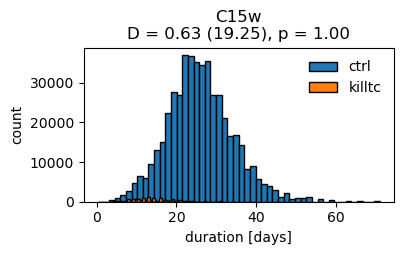

In [325]:
TS = 'C15w'
param = 'duration'

ctrl, ktc = [storage[storm_type]['AM2.5_tc_ctrl'], 
             storage[storm_type]['AM2.5_tc_ktc2']]

ctrl, ktc = [storage[storm_type]['HIRAM_tc_ctrl'], 
             storage[storm_type]['HIRAM_tc_ktc2']]

fig, ax = plt.subplots(figsize=(4, 2))

ctrl_label, ktc_label = ['ctrl (N={0})'.format(len(ctrl['storm_id'].unique())),
                         'killTC (N={0})'.format(len(ktc['storm_id'].unique()))]
ctrl[param].hist(bins=50, ec='k', grid=False, ax=ax, label=ctrl_label)
ktc[param].hist(bins=50, ec='k', grid=False, ax=ax, label=ktc_label)

ks_stats = scipy.stats.kstest(np.random.choice(ctrl[param], size=len(ctrl[param])//2), 
                              np.random.choice(ktc[param], size=len(ktc[param])//2))
stat_str = 'D = {0:.2f} ({1:.2f}), p = {2:.2f}'.format(ks_stats.statistic, 
                                                       ks_stats.statistic_location, 
                                                       1-ks_stats.pvalue)

if param == 'slp':
    ax.set_xlabel('min sea level pressure [hPa]')
elif param == 'max_wnd':
    ax.set_xlabel('max 10m wind [m s$^{-1}$]')
elif param == 'duration':
    ax.set_xlabel('duration [days]')

ax.set_ylabel('count')
ax.set_yscale('linear')
ax.set_title('{0}\n{1}'.format(storm_type, stat_str))
ax.legend(frameon=False)

In [18]:
(60-2761)/2761

-0.9782687432089823

#### Comparative distribution plots

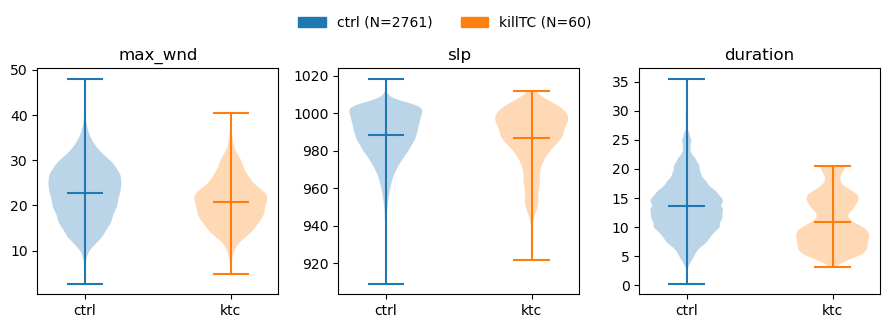

In [17]:
storm_type = 'C15w'
ctrl, ktc = [storage[storm_type]['AM2.5_tc_ctrl'], 
             storage[storm_type]['AM2.5_tc_ktc2']]

params= ['max_wnd', 'slp', 'duration']
ncols = len(params)

fig, axs = plt.subplots(ncols=ncols, figsize=(3*ncols, 3))
x_pos = [1, 2]
for i, ax in enumerate(axs):
    ax.violinplot(ctrl[params[i]], [x_pos[0]], showmeans=True, showextrema=True)
    ax.violinplot(ktc[params[i]], [x_pos[1]], showmeans=True, showextrema=True)
    ax.set_xticks(x_pos, ['ctrl', 'ktc'])
    ax.set_title(params[i])

ctrl_label, ktc_label = ['ctrl (N={0})'.format(len(ctrl['storm_id'].unique())),
                         'killTC (N={0})'.format(len(ktc['storm_id'].unique()))]
patches = [mpatches.Patch(color='tab:blue', label=ctrl_label), 
           mpatches.Patch(color='tab:orange', label=ktc_label)]
fig.legend(handles=patches, frameon=False, ncols=2, loc='upper center', bbox_to_anchor=(0.5, 1.1))
    
fig.tight_layout()

#### Comparative timeseries

In [ ]:
storm_type = 'TS'
ctrl, ktc = [storage[storm_type]['AM2.5_tc_ctrl'], 
             storage[storm_type]['AM2.5_tc_ktc2']]

params = ['max_wnd', 'slp', 'duration']
ncols = len(params)

fig, axs = plt.subplots(ncols=ncols, figsize=(3*ncols, 3))

ctrl_plot = ctrl.drop_duplicates('storm_id')
ctrl_plot['time'] = pd.to_datetime(ctrl.drop_duplicates('storm_id')['time'], format='%Y%m%d%H')
ctrl_plot = ctrl_plot.set_index('time').groupby(pd.Grouper(freq='Y')).mean()

ktc_plot = ktc.drop_duplicates('storm_id')
ktc_plot['time'] = pd.to_datetime(ktc.drop_duplicates('storm_id')['time'], format='%Y%m%d%H')
ktc_plot = ktc_plot.set_index('time').groupby(pd.Grouper(freq='Y')).mean()

for i, ax in enumerate(axs):
    ax.plot(ctrl_plot[params[i]], marker='o', markersize=4)
    ax.plot(ktc_plot[params[i]], marker='o', markersize=4)
    ax.set_title(params[i])
    
    
fig.tight_layout()

#### Visualize tracks

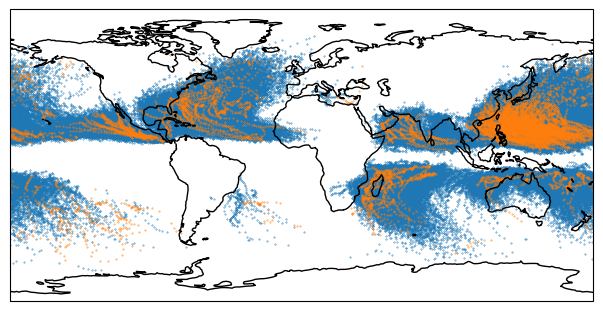

In [289]:
fig = plt.figure(figsize=(7, 3), constrained_layout=True)
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(1, 0.03))
ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())

ax.coastlines()
ax.set_extent([-180, 180, -90, 90])

colors = ['tab:blue', 'tab:orange']

storm_type = 'C15w'
# model_runs = ['AM2.5_tc_ctrl', 'AM2.5_tc_ktc2']
model_runs = ['HIRAM_tc_ctrl', 'HIRAM_tc_ktc2']

for i, model_run in enumerate(model_runs):

    data = storage[storm_type][model_run]

    for storm in data['storm_num'].unique():
        storm_data = data.loc[data['storm_num'] == storm]

        if sum(storm_data['flag'] > 0) > 0:
            storm_data = storm_data.where(storm_data['flag'] > 0)
            ax.scatter(storm_data['lon'], storm_data['lat'], 
                       s=0.1, c=colors[i], transform=ccrs.PlateCarree())

#### Track density heatmap
Note: this has to be refined to only count unique storms

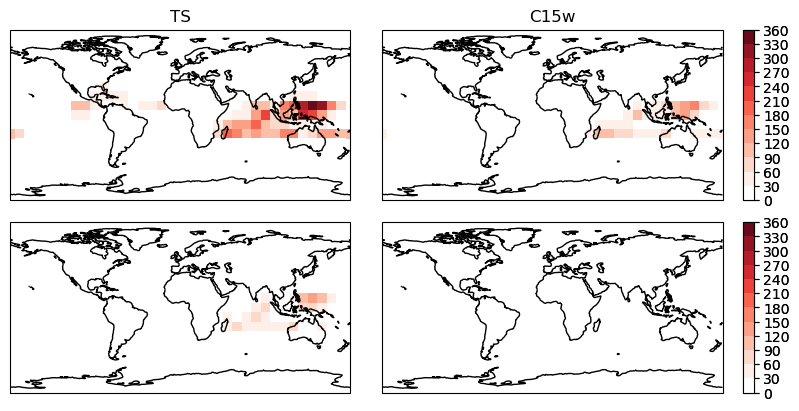

In [292]:
''' Data processing. '''

# Define storm types ('TS' = all storms, 'C15w' = hurricanes)
storm_types = ['TS', 'C15w']
# Define model runs analyzed
model_runs = ['AM2.5_tc_ctrl', 'AM2.5_tc_ktc2']
# Boolean to specify cyclogenesis location
unique_storms = True
# Compile list of storm count DataFrames for all storm types and model runs specified
# This will be concatenated after the double-loop
total_counts = []
# Iterate over model runs and storm types
for i, model_run in enumerate(model_runs):
    for j, storm_type in enumerate(storm_types):
        # Pull data for the iterand storm type and model run
        data = storage[storm_type][model_run]
        # Get cyclogenesis data point if boole
        if unique_storms:
            data = data.drop_duplicates('storm_id')
        # Define dictionary to hold data relevant to track density heatmap
        counts = {'lon': [], 'lat': [], 'count': []}
        # Define resolution for count binning
        res = 10
        # Group DataFrame into defined bins and add storm counts to the dictionary
        for lon_g, lon_v in data.groupby(pd.cut(data['lon'], np.arange(0, 360+res, res))):
            for lat_g, lat_v in lon_v.groupby(pd.cut(lon_v['lat'], np.arange(-90, 90+res, res))):
                counts['lon'].append(lon_g.left)
                counts['lat'].append(lat_g.left)
                counts['count'].append(len(lat_v))
        # Create DataFrame from the dictionary
        counts = pd.DataFrame(counts)
        # Add metadata to the DataFrame
        counts['storm_type'] = storm_type
        counts['model_run'] = model_run
        # Add DataFrame to a list for future concatenation
        total_counts.append(counts)
# Concatenate to get comprehensive DataFrame
total_counts = pd.concat(total_counts)
 
''' Plotting. '''
    
fig = plt.figure(figsize=(8, 4), constrained_layout=True)
gs = fig.add_gridspec(nrows=len(model_runs), ncols=len(storm_types)+1, width_ratios=(1, 1, 0.03))

# Enable normalization outside the loop (None if runs are from different models)
norm = None
if len(set([m.split('_')[0] for m in model_runs])) == 1:
    model_counts = total_counts.loc[total_counts['model_run'].isin(model_runs)]
    norm = matplotlib.colors.Normalize(vmin=model_counts['count'].min(), vmax=model_counts['count'].max()) 

for i, model_run in enumerate(model_runs):
    
    model_counts = total_counts.loc[total_counts['model_run'] == model_run]
    if norm == None:
        norm = matplotlib.colors.Normalize(vmin=model_counts['count'].min(), vmax=model_counts['count'].max()) 
    
    # Refine normalization bounds to avoid weird colorbar ticks and intervals
    base = 10
    norm.vmax = base * round(norm.vmax/base)
    
    for j, storm_type in enumerate(storm_types):    
        
        storm_counts = model_counts.loc[model_counts['storm_type'] == storm_type]
        
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([-180, 180, -90, 90])
        # Adjust colormap to go from full white to the specified colormap's color
        cmap = cmap_white_adjust('Reds', levels=12)
        # Reshape 1-D array to be a 2-D array with dimensions (N_lon, N_lat)
        count = np.reshape(storm_counts['count'].values, 
                           newshape=(len(storm_counts['lon'].unique()), len(storm_counts['lat'].unique())))
        im = ax.pcolormesh(storm_counts['lon'].unique(), storm_counts['lat'].unique(), count.T, 
                           norm=norm, cmap=cmap, transform=ccrs.PlateCarree())
        
        cax = fig.add_subplot(gs[i, -1])
        fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, 
                     ticks=np.linspace(0, norm.vmax, cmap.N+1))
        
        if i == 0:
            ax.set_title(storm_type)

#### Method to parse through Luca Harris' TC run output

In [6]:
def lmh_parser(path):
    
    ''' This method parses through text files from Lucas Harris' run outputs (held in directories titled 'analysis_lmh') 
    and produces an output DataFrame. '''
    
    # Create file object instance
    fobj = open(path, 'r').readlines()
    # Initialize dictionary to hold data
    data = {'storm_num': {}}
    # Initialize storm counter
    count = 1
    # Iterate through text file
    for line in fobj:
        # Extract information from the line
        content = line.strip()
        # Creates new storm-specific dict in the parent dict. The '+++' demarcates a new storm.
        if '+++' in line:
            storm_num = '{0:04d}'.format(count)
            data['storm_num'][storm_num] = {'storm_id': [], 'time': [], 'lon': [], 'lat': [], 'slp': [], 'max_wnd': [], 'flag': []}
            count += 1
        # Populates the storm-specific dict
        else:
            storm_num = '{0:04d}'.format(count-1) 
            tc_info = [x for x in content.split(' ') if x]
            year = tc_info[0][0:4] # get 4-digit year
            data['storm_num'][storm_num]['storm_id'].append('{0}-{1:04d}'.format(year, count-1))
            data['storm_num'][storm_num]['time'].append(tc_info[0])
            data['storm_num'][storm_num]['lon'].append(tc_info[1])
            data['storm_num'][storm_num]['lat'].append(tc_info[2])
            data['storm_num'][storm_num]['slp'].append(tc_info[3])
            data['storm_num'][storm_num]['max_wnd'].append(tc_info[4])
            data['storm_num'][storm_num]['flag'].append(tc_info[5])
    
    try:
        # Converts the dictionary into a DataFrame
        df = pd.concat({k: pd.DataFrame(v).T for k, v in data.items()}, axis=1)['storm_num']
        df = df.explode(df.columns.to_list()).reset_index().rename(columns={'index': 'storm_num'})
        # Re-cast column data types
        df = df.astype({'lon': 'float', 'lat': 'float', 'slp': 'float', 'max_wnd': 'float', 'flag': 'float'})
    except:
        df = pd.DataFrame(columns=['storm_id', 'time', 'lon', 'lat', 'slp', 'max_wnd', 'flag'])
    
    return df

#### Modify colormap to start at pure white

In [291]:
def cmap_white_adjust(cmap, levels=None):
    ''' Adjust a sequential monochromatic colormap to go from white to the monochrome. '''
    if levels:
        cm = matplotlib.colormaps[cmap].resampled(levels)
    else:
        cm = matplotlib.colormaps[cmap]
    cm = cm(np.arange(cm.N))
    cm = cm[:, :] + np.array([0, 1-cm[0, 1], 1-cm[0, 2], 0])
    cm = matplotlib.colors.ListedColormap(cm)
    return cm